In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter
from scipy.stats.stats import pearsonr

from datetime import datetime

In [2]:
url = 'https://raw.githubusercontent.com/ZioTrib/dm2proj/master/datatraining.csv'
df = pd.read_csv(url) 

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df = df.set_index(['date'])

# TS preparation

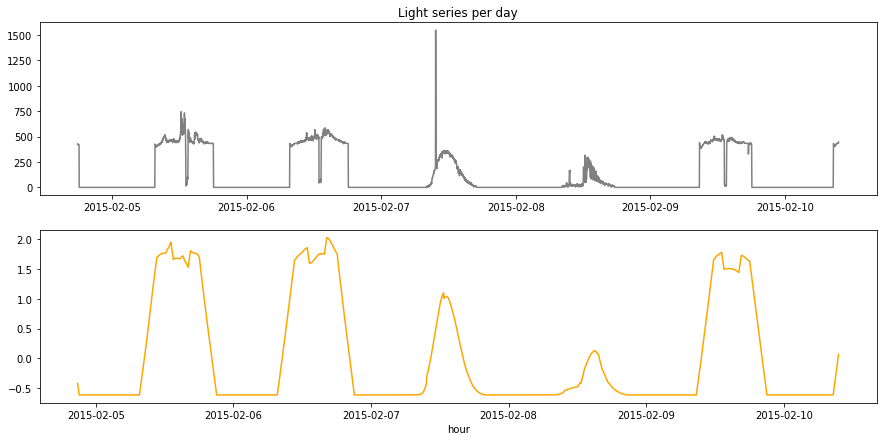

In [5]:
w = 180
plt.figure(figsize=(15,7))
plt.subplot(212)
df_denoised = ((df['Light']-df['Light'].mean())/df['Light'].std()).rolling(window=w).mean()
plt.plot(df_denoised, c = 'orange')
plt.xlabel('hour')

plt.subplot(211)
plt.plot(df['Light'], c = 'grey')

plt.title('Light series per day')
plt.show()

## Trend on Denoised

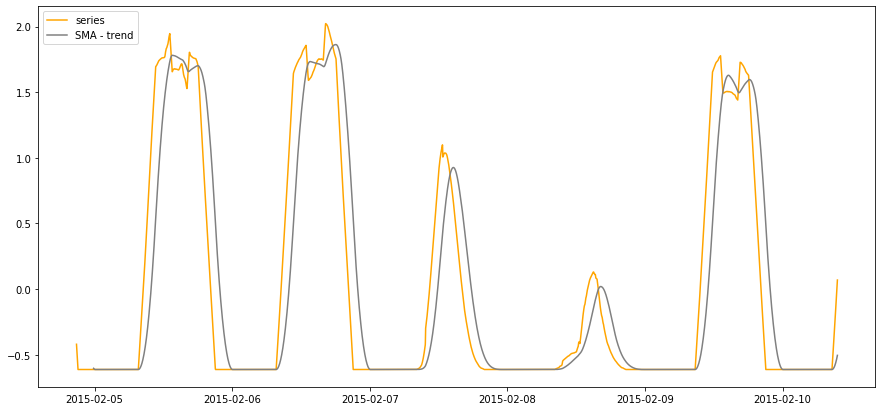

In [608]:
ts = df_denoised.loc['2015-02-04':'2015-02-10']
sma = ts.rolling(window = 180).mean()       #simple moving average
plt.figure(figsize=(15,7))
plt.plot(ts, c ='orange')
plt.plot(sma, c = 'grey')
plt.legend(['series','SMA - trend'], loc = 'upper left')   
plt.show()

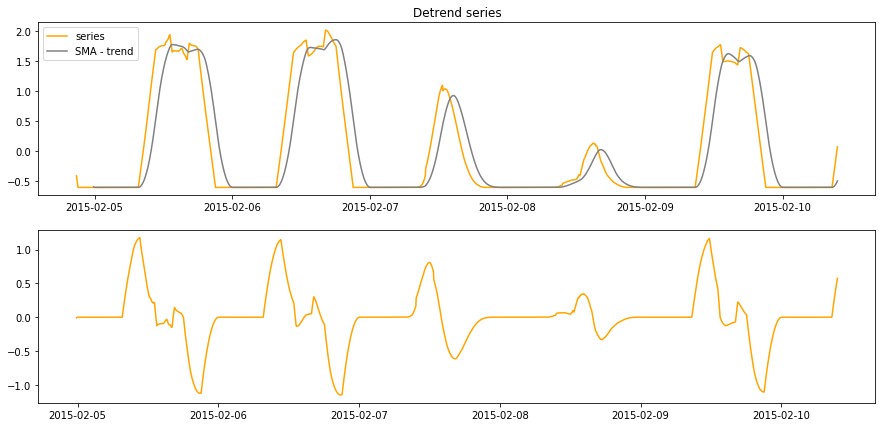

In [609]:
plt.figure(figsize=(15,7))
plt.subplot(211)
ts = df_denoised.loc['2015-02-04':'2015-02-10']
sma = ts.rolling(window = 180).mean()       #simple moving average
plt.plot(ts, c ='orange')
plt.plot(sma, c = 'grey')
plt.title('Detrend series')

plt.legend(['series','SMA - trend'], loc = 'upper left')   

plt.subplot(212)
ts_shift = ts - sma
plt.plot(ts_shift, c = 'orange')
plt.show()

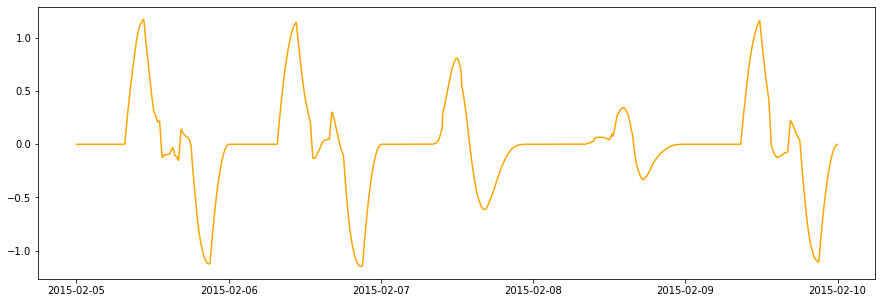

In [617]:
ts = ts_shift['2015-02-05':'2015-02-09']
plt.figure(figsize =(15,5))
plt.plot(ts, c = 'orange')

In [618]:
ts = ts.values

In [619]:
ts = ts.reshape(240, 30,-1) 

In [620]:
ts.shape

(240, 30, 1)

In [621]:
len(ts)

240

# TS approximation

In [622]:
#pip install tslearn

In [623]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

In [650]:
# SAX transform
n_paa_segments = 30
n_sax_symbols = 15
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_ts_inv = sax.inverse_transform(ts_sax)

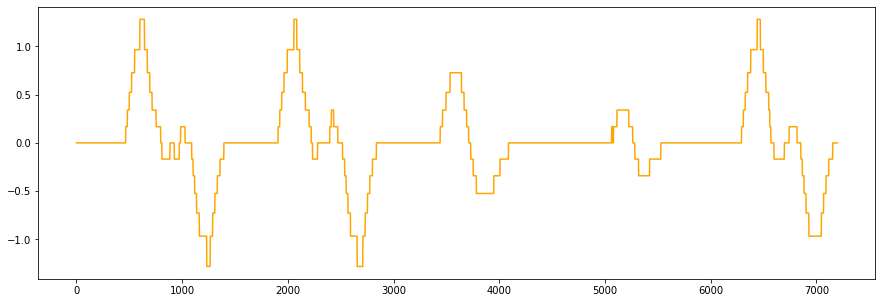

In [651]:
plt.figure(figsize = (15,5))
plt.plot(sax_ts_inv.ravel(), c = 'orange')
plt.show()

In [652]:
map_symbols = {k: v for v, k in enumerate(np.unique(sax_ts_inv.ravel()))}
map_symbols

{-1.2815515655446004: 0,
 -0.967421566101701: 1,
 -0.7279132908816442: 2,
 -0.5244005127080409: 3,
 -0.3406948270877956: 4,
 -0.16789400478810546: 5,
 0.0: 6,
 0.16789400478810546: 7,
 0.3406948270877954: 8,
 0.5244005127080407: 9,
 0.7279132908816444: 10,
 0.967421566101701: 11,
 1.2815515655446004: 12}

In [653]:
X_seq = list()
for x in sax_ts_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])

In [654]:
len(X_seq[0])

30

# Creating transactional DataSet

## items

dalla sequenza della sax sono stati presi i valori di ogni singolo segmento (items).

In [30]:
new_seq = []
for x in X_seq:
    new_seq.append(x[0])

In [31]:
len(new_seq)

240

## elements

ogni 4 items sono stati raccolti in un element (ogni element rappresenta 2 ore)

In [23]:
X_seq2H = []
i = 0
for i in range(0, 240, 4):
    X_seq2H.append((new_seq[i],new_seq[i+1],new_seq[i+2],new_seq[i+3]))

In [498]:
len(X_seq2H)

60

## sequence

ogni sequenza (corrispondente ad un differente giorno) è costituita da 12 elements

In [27]:
X_seqdef = []
i = 0
for i in range(0, 60, 12):
    X_seqdef.append([X_seq2H[i],X_seq2H[i+1],X_seq2H[i+2],
                     X_seq2H[i+3],X_seq2H[i+4],X_seq2H[i+5],
                     X_seq2H[i+6],X_seq2H[i+7],X_seq2H[i+8],
                     X_seq2H[i+9],X_seq2H[i+10],X_seq2H[i+11]])
    

In [41]:
len(X_seqdef)

5

# Sequential Pattern Mining

In [501]:
#pip install prefixspan

In [502]:
from prefixspan import PrefixSpan

https://github.com/chuanconggao/PrefixSpan-py
    
https://pypi.org/project/prefixspan/

In [761]:
ps = PrefixSpan(X_seqdef)

In [792]:
patterns = ps.frequent(2)
listafreq = []
for idx, i in enumerate(patterns):
    if len(patterns[idx][1])>= 3:
        listafreq.append(i)
len(listafreq)

27

In [795]:
patterns = ps.frequent(2, closed = True)
listafreq = []
for idx, i in enumerate(patterns):
    if len(patterns[idx][1])>= 3:
        listafreq.append(i)
len(listafreq)

6

In [808]:
patterns = ps.topk(6, closed = True )
listafreq = []
for idx, i in enumerate(patterns):
    if len(patterns[idx][1])>= 3:
        listafreq.append(i)
listafreq

[(5, [(6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6)]),
 (3, [(6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6), (3, 4, 5, 6)]),
 (3, [(6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6)]),
 (2,
  [(6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (1, 0, 0, 2),
   (3, 4, 5, 6)]),
 (2,
  [(6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (5, 6, 6, 6),
   (6, 6, 6, 6)]),
 (2,
  [(6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 6, 6, 6),
   (6, 4, 2, 1),
   (3, 4, 5, 6)])]